In [1]:
# numpy is the standard python array / vector library. We will use it to represent probabilities
import numpy as np
import scipy
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

### <b> 2. Context inference</b>

In this notebook we will see how context-dependent learning of such a Bayesian model works and how its parts influence context inference.

#### <b>2.1. Basic idea</b>

The basic idea is that the brain learns a model, as introduced in the previous notebook, separately for each discrete context!

<img src="Context_cat_small.png" width="800"/>

In our cat example that means, that you would learn a generative model, including state prior, observation likelihood, and state transition matrices, for each cat: One for Schmüffie, and one for Sir Hidesalot

When drawn as a Bayesian graph, it looks as follows (left with all arrows). Here, all green arrows and boxes are context dependent. Because this is a bit messy, the context-dependency is often drawn in a simplified way (right)

<img src="Context_gen_mod_arrows.png" width="300"/><img src="Context_generative_model_small.png" width="300"/>

For inference and planning, the basic idea is, that when the context is known (with certainty), you can just pick the corresponding generative model on the lower level, and infer the state, predict future states, and plan actions the exact same way we did on the previous notebooks. Then, when a context switch is detected, the brain can load the corresponding generative model and do inference and planning using that.

In our example that would mean, that the cat we are interacting with can be detected via the context cue for example (fur color, face shape, and so on), and I can use the different state transition and outcome probabilities for the respective cat, to and make an adaptive decision how to interect, e.g. pet for Schmüffie, but carry for Sir Hidesalot.

However, not all contexts are as easy to differentiate as two different cats. Sometimes, the context could be determined by just having a different habit in an otherwise similar situation. Or maybe I actually need two Schmüffie contexts, because she has a different state transition in summer vs winter, e.g. she could be really into petting when it is cold, but would rather not be petted when it is hot.

In such ambiguous cases, we need to *infer* what context we are in. We can again use Bayes to invert the arrows and send information to the context, and thereby calculate a posterior over contexts. We will take a closer look at that in the rest of this notebook.

<b>2.2. Context inference: Overview</b>

For inference, *all* context-dependent parts contribute information on how likely different contexts are

<img src="Context_inference_all.png" width="300"/>

Let's look into the different parts!

<b>1. Cue evidence</b> provides evidence for or against a context, if there was a direct context cue. In our case, seeing a black cat would provide cue evidence for being in the Schmüffie context.

<b>2. Observation evidence</b> from the observation likelihood $p(o_{t}|s_{t})$: After having observed an observation, and inferred the corresponding state, e.g. purr and good mood, you can evaluate whether the pair of both fits to the likelihood you have learned. The pair purr and good mood fits very well with the likelihood we have in our generative model for Schmüffie, so that would be not surprising and provide evidence for the Schmüffie context. Depending on whether Sir Hidesalot also purrs when is is in a good mood, or only purrs when he is unwell, we could have evidence for the Sir Hidesalot context as well, or lower evidence and higher surprise, respectively.

<b>3. State evidence</b> from both states $s_{t}$ and $s_{t+1}$. 

<b>3.a</b> For the state $s_{t}$ for which we had a prior, inferring any state with high likelihood that disagrees with the prior would lead to surprise and low evidence. 

<b>3.b</b> For the state $s_{t+1}$, the state evidence is higher when the experienced state transition given one's own action fits well to the state transition we have, i.e. if I observe petting lead to a bad mood, that would be evidence against the Schmüffie context, and evidence for the Sir Hidesalot context.

<b>4. Action evidence</b> provides evidence for a context if we behaved in a way that agrees with the learned prior/habit for this context. If we however behave in a way that disagrees with our habit for a context, that would be surprising and provide evidence against this context (and possibly for another one, where we have such a habit).

<b> 5. Context prior or transition</b> provides prior information about the possible context, before receiving evidence from the other terms. Similar to the state prior and transition, in the Bayesian framework we can learn how often different contexts occur in our environment, or how likely it is to go from one context into another. Since Schmüffie lives with me, I may have a high a priori assumption that a cat I encounter during my normal routines would be her.

#### <b>2.3. Example models</b>
Before we take a closer look at the contribution of the different context inference terms, let us define the example models for the two contexts: Schmüffie and Sir Hidesalot.

For Schmüffie, we can re-use the model from the previous notebook

<img src="Schmueffie_gen_mod_labels.png" width="300"/>

We had
* a prior over the first state $$p(s_{t}|c=\text{Schmüffie}) = \begin{pmatrix} 0.75\\0.25 \end{pmatrix} \begin{matrix} \text{good}\\ \text{bad}\end{matrix}$$
* an observation likelihood (and used the same for both $t$ and $t+1$) $$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{state:} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ p(o_{t}|s_{t},c=\text{Schmüffie}) = \textbf{observation:}\begin{matrix}\text{purr}\\ \text{walk away}\end{matrix}\begin{pmatrix} 0.9 & 0.2\\ 0.1 & 0.8 \end{pmatrix}$$
* state transition for action pet $$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{previous state $s_{t}$} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ p(s_{t+1}|s_{t},a_{t}=\text{pet},c=\text{Schmüffie}) = \textbf{new state $s_{t+1}$}\,\begin{matrix}\text{good}\\ \text{bad}\end{matrix}\begin{pmatrix} 0.99 & 0.6\\ 0.01 & 0.4 \end{pmatrix}$$
* state transition for action carry $$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{previous state $s_{t}$} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ p(s_{t+1}|s_{t},a_{t}=\text{carry},c=\text{Schmüffie}) = \textbf{new state $s_{t+1}$}\,\begin{matrix}\text{good}\\ \text{bad}\end{matrix}\begin{pmatrix} 0.3 & 0.1\\ 0.7 & 0.9 \end{pmatrix}$$
* a prior over the action $$p(a_{t}|c=\text{Schmüffie})=\begin{pmatrix} 0.67\\ 0.33  \end{pmatrix} \begin{matrix} \text{pet}\\ \text{carry} \end{matrix}$$

Note, that all the probabilities are now additionally conditioned on the context Schmüffie, to signify what context they belong to. But otherwise the numbers and shapes are the same as previously

In [2]:
# we represent the model in code again using numpy

prior_states_schmueffie = np.array([0.75, 0.25])

print("Schmüffie prior over states")
print(prior_states_schmueffie)

observation_likelihood_schmueffie = np.array([[0.9, 0.2], 
                                   [0.1, 0.8]])

print("Schmüffie observation likelihood")
print(observation_likelihood_schmueffie)

state_transition_matrix_schmueffie = np.array([
    [[0.99, 0.6],
     [0.01, 0.4]],
    [[0.3, 0.1],
     [0.7, 0.9]]
])

print("Schmüffie state transition matrix for action pet")
print(state_transition_matrix_schmueffie[0,:,:])

print("Schmüffie state transition matrix for action carry")
print(state_transition_matrix_schmueffie[1,:,:])

prior_actions_schmueffie = np.array([0.67, 0.33])

print("Prior over the action we typically use with Schmüffie")
print(prior_actions_schmueffie)

Schmüffie prior over states
[0.75 0.25]
Schmüffie observation likelihood
[[0.9 0.2]
 [0.1 0.8]]
Schmüffie state transition matrix for action pet
[[0.99 0.6 ]
 [0.01 0.4 ]]
Schmüffie state transition matrix for action carry
[[0.3 0.1]
 [0.7 0.9]]
Prior over the action we typically use with Schmüffie
[0.67 0.33]


For Sir Hidesalot, we use a new model that reflects how he is different from Schmüffie.

<img src="Sir_gen_mod_labels.png" width="300"/>

We define the follwing generative model for the Sir:
* He is shy so his prior over states is biased less towards happy compared to Schmüffie: $$p(s_{t}|c=\text{Sir H.}) = \begin{pmatrix} 0.55\\0.45 \end{pmatrix} \begin{matrix} \text{good}\\ \text{bad}\end{matrix}$$
* Which is also reflected in the observation likelihood, as he doesn't purr as much, and does hide a lot...$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{state:} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ p(o_{t}|s_{t},c=\text{Sir H.}) = \textbf{observation:}\begin{matrix}\text{purr}\\ \text{walk away}\end{matrix}\begin{pmatrix} 0.6 & 0.01\\ 0.4 & 0.99 \end{pmatrix}$$
* state transition for action pet (he doesn't like it)$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{previous state $s_{t}$} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ p(s_{t+1}|s_{t},a_{t}=\text{pet},c=\text{Sir H.}) = \textbf{new state $s_{t+1}$}\,\begin{matrix}\text{good}\\ \text{bad}\end{matrix}\begin{pmatrix} 0.3 & 0.85\\ 0.7 & 0.15 \end{pmatrix}$$
* state transition for action carry (he likes it)$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{previous state $s_{t}$} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ p(s_{t+1}|s_{t},a_{t}=\text{carry},c=\text{Sir H.}) = \textbf{new state $s_{t+1}$}\,\begin{matrix}\text{good}\\ \text{bad}\end{matrix}\begin{pmatrix} 0.9 & 0.65\\ 0.1 & 0.35 \end{pmatrix}$$
* Let's assume we learned a strong prior for carrying him because he likes it so much that we did it again and again$$p(a_{t}|c=\text{Sir H.})=\begin{pmatrix} 0.2\\ 0.8  \end{pmatrix} \begin{matrix} \text{pet}\\ \text{carry} \end{matrix}$$

In [3]:
prior_states_sir_h = np.array([0.55, 0.45])

print("Sir Hidesalot prior over states")
print(prior_states_sir_h)

observation_likelihood_sir_h = np.array([[0.6, 0.01], 
                                   [0.4, 0.99]])

print("Sir Hidesalot observation likelihood")
print(observation_likelihood_sir_h)

state_transition_matrix_sir_h = np.array([
    [[0.3, 0.85],
     [0.7, 0.15]],
    [[0.9, 0.65],
     [0.1, 0.35]]
])

print("Sir Hidesalot state transition matrix for action pet")
print(state_transition_matrix_sir_h[0,:,:])

print("Sir Hidesalot state transition matrix for action carry")
print(state_transition_matrix_sir_h[1,:,:])

prior_actions_sir_h = np.array([0.2, 0.8])

print("Prior over the action we typically use with Sir Hidesalot")
print(prior_actions_sir_h)

Sir Hidesalot prior over states
[0.55 0.45]
Sir Hidesalot observation likelihood
[[0.6  0.01]
 [0.4  0.99]]
Sir Hidesalot state transition matrix for action pet
[[0.3  0.85]
 [0.7  0.15]]
Sir Hidesalot state transition matrix for action carry
[[0.9  0.65]
 [0.1  0.35]]
Prior over the action we typically use with Sir Hidesalot
[0.2 0.8]


With this, we have defined all rules and priors for the two possible contexts. Note, that every term that is conditioned on the context will send evidence for context inference! And in our example, this is every term. It could however also be that only some of these probabilities are context dependent, whereas others are the same accross context. In this case, they would not send evidence to the context.

#### <b>2.4. Upper level rules</b>

Before we can run some examples with numbers below, we need to finally specify the priors and rules on the top of the model hierarchy, i.e. the context prior and the context cue likelihood.

<img src="Gen_mod_top_level.png" width="250"/>

First, we can specify the context prior as
$$p(c) = \begin{pmatrix} 0.7\\0.3 \end{pmatrix} \begin{matrix} \text{Schmüffie}\\ \text{Sir H.}\end{matrix}$$
with a bias for Schmüffie, as we have seen her more often.

Second, we can specify the context cue likelihood as
$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{context:} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{Schmüffie} & \text{Sir H.}\end{matrix}\\ p(o_{c}|c) = \textbf{observation:}\begin{matrix}\text{black}\\ \text{brown}\end{matrix}\begin{pmatrix} 0.9 & 0.1\\ 0.1 & 0.9 \end{pmatrix}$$

In [4]:
prior_contexts = np.array([0.7, 0.3])

print("prior over contexts (cats)")
print(prior_contexts)

context_cue_likelihood = np.array([[0.9, 0.1],
                                   [0.1, 0.9]])

print("context cue likelihood")
print(context_cue_likelihood)

prior over contexts (cats)
[0.7 0.3]
context cue likelihood
[[0.9 0.1]
 [0.1 0.9]]


With everything specified, we can now take a deeper look into the context inference components

#### <b>2.5. Observation evidence

In this part and the following, we will make the assumption that we have observed a full loop, i.e. we have observed the observation $o_{t}$, inferred $s_{t}$, made plans and chose an action $a_{t}$, then we observed our outcome $o_{t+1}$, which we in turn used to make an inference about the next state $s_{t+1}$. Based on such a whole behavioral episode, we can now infer what context we were in, i.e. which cat we interacted with. Admittedly, with the cats looking so different, and the context cue likelihood being so pronounced, it is rather easy to do that, however, the brain is able to do this even without explicit clues.

Specifically, let us assume we first observed "walk away", executed the action "carry" and then observed the observation "purr".

For the observation evidence, we calculate evidence from the two observations that we have made, similar to what we did in the previous notebook

<img src="Inference_observation_likelihood.png" width="300"/>

To do this, we take the row of the observation likelihood matrix, that corresponds to the observation we made for both, $o_{t}$ and $o_{t+1}$, i.e. $$p(o_{t}=\text{walk away}|s_{t}, c)$$ and $$p(o_{t+1}=\text{purr}|s_{t+1}, c)$$

For <b>Schmüffie</b> we get the following:

We use the observation likelihood for $o_{t}=\text{walk away}$ at time $t$, its evidence, and the information about the corresponding state $s_{t}$ in the form of the normalized observation likelihood

In [5]:
print("Schmüffie's observation likelihood for walking")
print(observation_likelihood_schmueffie[1])

evidence_observation_like_schmueffie_o_t = observation_likelihood_schmueffie[1].sum()
print("evidence for o_t=walking context=Schmüffie")
print(evidence_observation_like_schmueffie_o_t)

normalized_observation_likelihood_schmueffie_o_t = observation_likelihood_schmueffie[1] / evidence_observation_like_schmueffie_o_t

print("Schmüffie's normalized observation likelihood for o_t for walking away")
print(normalized_observation_likelihood_schmueffie_o_t)

Schmüffie's observation likelihood for walking
[0.1 0.8]
evidence for o_t=walking context=Schmüffie
0.9
Schmüffie's normalized observation likelihood for o_t for walking away
[0.11111111 0.88888889]


From this we can see that walking away has medium evidence ($0.9$) and the "walk away" observation signals that Schmüffie was most likely in a bad mood in $s_{t}$ (89%). That is, if we were to base our inference solely on the observation and would ignore the prior (see below in 2.5.1. for how we use the prior for context inference).

The follwing implements the observation likelihood for $o_{t+1}=\text{purr}$ at time $t+1$, its evidence, and the information about the corresponding state $s_{t+1}$ in the form of the normalized observation likelihood

In [6]:
print("Schmüffie's observation likelihood for purring")
print(observation_likelihood_schmueffie[0])

evidence_observation_likelihood_schmueffie_o_t_1 = observation_likelihood_schmueffie[0].sum()

print("evidence o_t+1=purr context=Schmüffie")
print(evidence_observation_likelihood_schmueffie_o_t_1)

normalized_observation_likelihood_schmueffie_o_t_1 = observation_likelihood_schmueffie[0]/evidence_observation_likelihood_schmueffie_o_t_1

print("Schmüffie's normalized observation likelihood for o_t+1 for purring")
print(normalized_observation_likelihood_schmueffie_o_t_1)

Schmüffie's observation likelihood for purring
[0.9 0.2]
evidence o_t+1=purr context=Schmüffie
1.1
Schmüffie's normalized observation likelihood for o_t+1 for purring
[0.81818182 0.18181818]


From this we can see that purring has a bit higher evidence ($1.1$), as Schmüffie is overall more likely to purr than to wak away, given her model. The "purr" observation signals that Schmüffie was most likely in a good mood in $s_{t+1}$ (81%), if we base our inference solely on the observation and ignore the state transition. We will look at the influence of the state transition below in 2.5.2.

We can now use both evidences together by multiplying them to get the total observation evidence for $c=\text{Schmüffie}$:

In [7]:
observation_evidence_schmueffie= evidence_observation_like_schmueffie_o_t*evidence_observation_likelihood_schmueffie_o_t_1

print("total evidence from observations for Schmüffie")
print(observation_evidence_schmueffie)

total evidence from observations for Schmüffie
0.9900000000000001


Based on the two observations, the context Schmüffie has the an evidence of $0.99$.

And for <b>Sir Hidesalot</b>

The follwing implements the observation likelihood for $o_{t}=\text{walk away}$ at time $t$, its evidence, and the information about the corresponding state $s_{t}$ in the form of the normalized observation likelihood

In [8]:
print("Sir Hidesalot's observation likelihood for walking")
print(observation_likelihood_sir_h[1])

evidence_observation_like_sir_h_o_t = observation_likelihood_sir_h[1].sum()
print("evidence for o_t=walking context=Sir Hidesalot")
print(evidence_observation_like_sir_h_o_t)

normalized_observation_likelihood_sir_h_o_t = observation_likelihood_sir_h[1] / evidence_observation_like_sir_h_o_t

print("Sir Hidesalot's normalized observation likelihood for o_t for walking away")
print(normalized_observation_likelihood_sir_h_o_t)

Sir Hidesalot's observation likelihood for walking
[0.4  0.99]
evidence for o_t=walking context=Sir Hidesalot
1.3900000000000001
Sir Hidesalot's normalized observation likelihood for o_t for walking away
[0.28776978 0.71223022]


From this we can see that walking away has rather high evidence ($1.3$), which is higher than Schmüffie's evidence observation evidence for $o_{t}$ at time $t$. This is because Sir Hidesalot is overall more likely to walk away given his generative model than Schmüffie. Also the "walk away" observation signals that Sir Hidesalot was probably in a bad mood in $s_{t}$ (71%) if we were to base our inference solely on the observation and would ignore the prior, see below in 2.5.1. for how we use the prior for state inference.

The follwing implements the observation likelihood for $o_{t+1}=\text{purr}$ at time $t+1$, its evidence, and the information about the corresponding state $s_{t+1}$ in the form of the normalized observation likelihood

In [9]:
print("Sir Hidesalot's observation likelihood for purring")
print(observation_likelihood_sir_h[0])

evidence_observation_likelihood_sir_h_o_t_1 = observation_likelihood_sir_h[0].sum()

print("evidence o_t+1=purr context=Sir Hidesalot")
print(evidence_observation_likelihood_sir_h_o_t_1)

normalized_observation_likelihood_sir_h_o_t_1 = observation_likelihood_sir_h[0]/evidence_observation_likelihood_sir_h_o_t_1

print("Sir Hidesalot's normalized observation likelihood for o_t+1 for purring")
print(normalized_observation_likelihood_sir_h_o_t_1)

Sir Hidesalot's observation likelihood for purring
[0.6  0.01]
evidence o_t+1=purr context=Sir Hidesalot
0.61
Sir Hidesalot's normalized observation likelihood for o_t+1 for purring
[0.98360656 0.01639344]


From this we can see that purring has lower evidence ($0.61$), as Sir Hidesalot is overall less likely to purr than to wak away, given his model. The "purr" observation signals that Sir Hidesalot was almost certainly in a good mood in $s_{t+1}$ (98%), if we base our inference solely on the observation and ignore the state transition. We will look at the influence of the state transition below in 2.5.2.

We can now use both evidences together by multiplying them to get the total observation evidence for $c=\text{Sir H.}$:

In [10]:
observation_evidence_sir_h = evidence_observation_like_sir_h_o_t*evidence_observation_likelihood_sir_h_o_t_1

print("total evidence from observations for Sir Hidesalot")
print(observation_evidence_sir_h)

total evidence from observations for Sir Hidesalot
0.8479000000000001


Let's plot the overall observation evidence results

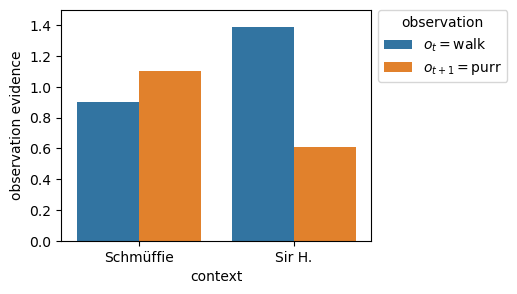

In [11]:
obs_evidence_list = [evidence_observation_like_schmueffie_o_t, evidence_observation_likelihood_schmueffie_o_t_1, evidence_observation_like_sir_h_o_t, evidence_observation_likelihood_sir_h_o_t_1]

plot_obs_evidence = pd.DataFrame({"observation": ["$o_{t}=$walk", "$o_{t+1}=$purr", "$o_{t}=$walk", "$o_{t+1}=$purr"], "observation evidence": obs_evidence_list, 
                                     "context": ["Schmüffie", "Schmüffie", "Sir H.", "Sir H."]})

plt.figure(figsize=[4,3])
ax = sns.barplot(data=plot_obs_evidence, x="context", y="observation evidence", hue="observation")
plt.ylim([0,1.5])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.03))
plt.show()

Comparing the evidences we see that observation "walk away" leads to having more evidence for Sir Hidesalot, while the observation "purr" yeilds more evidence for Schmüffie. This is because Schmüffie is overall more likely to purr according to her observation likelihood matrix, while Sir Hidesalot is overall more likely to walk away according to his matrix.

In regards to the total evidence for the two, we right now have a bit more evidence for Schmüffie ($0.99$) vs. Sir Hidesalot ($0.85$) - taking only the observations into account. That comes from the fact that she has a more pronounced and less uncertain observation probability matrix.

Note, that the main factor that will drive context inference is the relative difference between evidences (e.g. the two blue bars), i.e. how certain the evidence is. Absolute values do not play a role in the end. Here, the two orange bars have a sharper difference than the blue bars, which is why Schmüffies total evidence is larger here.

#### <b>2.6. State evidence

We can separate the state evidence into two parts: The first state, where we will get information how well the first observation fit to the prior, and the second state, where we get information how well the state transition fit to each cat.

##### <b>2.6.1. State evidence with prior for $s_{t}$

For the state evidence of $s_{t}$, we compare how well the information from the observation fits to the prior, i.e. does what we just observed fit with our general knowledge about the usual state of the cat, and does it fit better to one over the other?

<img src="Inference_s_t.png" width="300"/>

To do this we use the observation likelihoods we just calculated above and use the inference procedure for $s_{t}$ from the previous notebook:

$$p(s_{t}|o_{t}=\text{walk away},c) \propto p(o_{t}=\text{walk away}|s_{t},c)p(s_{t}|c)$$

For the first term we will use the normalized observation likelihood from above, and for the second term we use the context/cat-specific prior over states from the generative model.

For <b>Schmüffie</b> we get

In [12]:
unnormalized_posterior_states_schmueffie_walk = normalized_observation_likelihood_schmueffie_o_t * prior_states_schmueffie

evidence_state_schmueffie_s_t = unnormalized_posterior_states_schmueffie_walk.sum()
print("evidence for s_t context=Schmüffie")
print(evidence_state_schmueffie_s_t)

# and in order to get a probability of each state, we normalize this
posterior_states_schmueffie_walk = unnormalized_posterior_states_schmueffie_walk / evidence_state_schmueffie_s_t

print("Schmueffie's normalized posterior over states for observation walking")
print(posterior_states_schmueffie_walk)

evidence for s_t context=Schmüffie
0.3055555555555556
Schmueffie's normalized posterior over states for observation walking
[0.27272727 0.72727273]


Recall that the normalized observation likelihood from above was $\begin{pmatrix} 0.11\\ 0.89 \end{pmatrix} \begin{matrix} \text{good}\\ \text{bad}\end{matrix}$ and pointed towards a bad mood given the observation "walk away". However, she has a prior over states where she is happy in 75% of the time. Therefore, the information we got from the observation *does not* fit to the prior. This leads to her evidence for the state $s_{t}$ being a rather low $0.31$.

Nonetheless, we can infer her posterior over states, which we will also have to use below to get the state transition evidence:
$$p(s_{t}|o_{t}=\text{walk away},c=\text{Schmüffie})=\begin{pmatrix} 0.27 \\ 0.73\end{pmatrix}\begin{matrix} \text{good} \\ \text{bad}\end{matrix}$$
i.e. if we do observe her walking away, she is in a bad mood with a probability of 73%.

For <b>Sir Hidesalot</b> we get

In [13]:
unnormalized_posterior_states_sir_h_walk = normalized_observation_likelihood_sir_h_o_t * prior_states_sir_h

evidence_state_sir_h_s_t = unnormalized_posterior_states_sir_h_walk.sum()
print("evidence for s_t context=Sir Hidesalot")
print(evidence_state_sir_h_s_t)

# and in order to get a probability of each state, we normalize this
posterior_states_sir_h_walk = unnormalized_posterior_states_sir_h_walk / evidence_state_sir_h_s_t

print("Sir Hidesalot's normalized posterior over states for observation walking")
print(posterior_states_sir_h_walk)

evidence for s_t context=Sir Hidesalot
0.4787769784172662
Sir Hidesalot's normalized posterior over states for observation walking
[0.33057851 0.66942149]


His normalized observation likelihood from above was $\begin{pmatrix} 0.29\\ 0.71 \end{pmatrix} \begin{matrix} \text{good}\\ \text{bad}\end{matrix}$ and while it does point towards a bad mood, it does less so than Schmüffie's. Additonally, his prior over states has him happy only in 55% of the time. Therefore, the information we got from the observation only lightly points into the opposite direction from the prior. This leads to his evidence for the state $s_{t}$ being higher than Schmüffie's at $0.48$.

From this, we can infer Sir Hidesalot's posterior over states $s_{t}$ to be used below as
$$p(s_{t}|o_{t}=\text{walk away},c=\text{Sir H.})=\begin{pmatrix} 0.33 \\ 0.67\end{pmatrix}\begin{matrix} \text{good} \\ \text{bad}\end{matrix}$$
His mood is bad with a 67% probability.

In summary, for the first state $s_{t}$ we have higher evidence for Sir Hidesalot, since his prior and observation likelihood were less contradictory.

##### <b>2.6.2. State evidence with state transition for $s_{t+1}$

For the state evidence of $s_{t+1}$, we compare how well the information from the observation fits to state transition that we caused with out behavior, i.e. does what we just as a consequence fit with our knowledge about how the respective cat reacts to certain actions?

<img src="Inference_state_trans.png" width="300"/>

To do this, we will use the posterior over $s_{t}$ we just calculated and send it through the transition matrix for the "carry" action to get a prediction for $s_{t+1}$. We will then compare this with the observation likelihood of the second observation $o_{t+1}$ from further above, and also calculate a posterior over future states, according to:

$$p(s_{t+1}|o_{t}=\text{walk away},o_{t+1}=\text{purr},a_{t}=\text{carry},c) \propto p(o_{t+1}=\text{purr}|s_{t+1},o_{t}=\text{walk away},a_{t}=\text{carry},c)p(s_{t+1}|c,a_{t}=\text{carry})$$

For <b>Schmüffie</b> we get the following predicted state:

In [14]:
# use dot to send the posterior over the first state through the state transition matrix for carry

prior_future_state_schmueffie_walk_carry = np.dot(state_transition_matrix_schmueffie[1,:,:], posterior_states_schmueffie_walk)

print("prior over future states after observing walk away and doing carry")
print(prior_future_state_schmueffie_walk_carry)

prior over future states after observing walk away and doing carry
[0.15454545 0.84545455]


We had a posterior over the first state of $\begin{pmatrix} 0.27 \\ 0.73\end{pmatrix}\begin{matrix} \text{good} \\ \text{bad}\end{matrix}$ (i.e. we already inferred Schmüffie to be in a bad mood due to her walking away) and send it through the transition matrix for carry (which she doesn't like): $$\quad\quad\quad\quad s_{t} \\ \quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ s_{t+1}\,\begin{matrix}\text{good}\\ \text{bad}\end{matrix}\begin{pmatrix} 0.3 & 0.1\\ 0.7 & 0.9 \end{pmatrix}$$

and get for the predicted state
$$p(s_{t+1}|c=\text{Schmüffie},o_{t}=\text{walk},a_{t}=\text{carry}) = \begin{pmatrix} 0.15 \\ 0.85\end{pmatrix}\begin{matrix} \text{good} \\ \text{bad}\end{matrix}$$
that we are even more certain that she is in a bad mood, since she already signalled it through walking away, and then we did an action that is even more likely to get her in a bad mood... (No cats were harmed for this notebook! Except maybe for an extensive photoshoot :P)

Now we compare this prediction with the information we got from observing purr for $o_{t+1}$. We had a normalized observation likelihood of $\begin{pmatrix} 0.82 \\ 0.18\end{pmatrix}\begin{matrix} \text{good} \\ \text{bad}\end{matrix}$ where the purring signals a good possibly goood mood.


In [15]:
unnormalized_posterior_states_schmueffie_walk_carry_purr = normalized_observation_likelihood_schmueffie_o_t_1 * prior_future_state_schmueffie_walk_carry

evidence_state_schmueffie_s_t_1 = unnormalized_posterior_states_schmueffie_walk_carry_purr.sum()

print("unnormalized future state Schmüffie")
print(unnormalized_posterior_states_schmueffie_walk_carry_purr)

print("state transition evidence Schmüffie")
print(evidence_state_schmueffie_s_t_1)

normalized_posterior_future_state_schmueffie = unnormalized_posterior_states_schmueffie_walk_carry_purr/evidence_state_schmueffie_s_t_1

unnormalized future state Schmüffie
[0.12644628 0.15371901]
state transition evidence Schmüffie
0.2801652892561983


As is already visible from the numbers above the code cell, the predicted state state and the information from the purring observation are contradictory. Hence the evidence for this sequence of events is rather low at $0.28$.

For <b>Sir Hidesalot</b> we get the following predicted state

In [16]:
# use dot to send the posterior over the first state through the state transition matrix for carry

prior_future_state_sir_h_walk_carry = np.dot(state_transition_matrix_sir_h[1,:,:], posterior_states_sir_h_walk)

print("prior over future states after observing walk away and doing carry")
print(prior_future_state_sir_h_walk_carry)

prior over future states after observing walk away and doing carry
[0.73264463 0.26735537]


We had a posterior over the first state of $\begin{pmatrix} 0.33 \\ 0.67\end{pmatrix}\begin{matrix} \text{good} \\ \text{bad}\end{matrix}$ (i.e. we inferred Sir Hidesalot to be in a bad mood, albeit a little less likely than Schmüffie) and send it through the transition matrix for carry (which he likes!): $$\quad\quad\quad\quad s_{t} \\ \quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ s_{t+1}\,\begin{matrix}\text{good}\\ \text{bad}\end{matrix}\begin{pmatrix} 0.9 & 0.65\\ 0.1 & 0.35 \end{pmatrix}$$

and get for the predicted state
$$p(s_{t+1}|c=\text{Sir H.},o_{t}=\text{walk},a_{t}=\text{carry}) = \begin{pmatrix} 0.73 \\ 0.27\end{pmatrix}\begin{matrix} \text{good} \\ \text{bad}\end{matrix}$$
that we are somewhat certain that he may be in a good mood after carrying him, despite him walking away at first :D

Now we compare this prediction with the information we got from observing purr for $o_{t+1}$. We had a normalized observation likelihood of $\begin{pmatrix} 0.98 \\ 0.02\end{pmatrix}\begin{matrix} \text{good} \\ \text{bad}\end{matrix}$ where the purring signals a good mood with very high certainty!


In [17]:
unnormalized_posterior_states_sir_h_walk_carry_purr = normalized_observation_likelihood_sir_h_o_t_1 * prior_future_state_sir_h_walk_carry

evidence_state_sir_h_s_t_1 = unnormalized_posterior_states_sir_h_walk_carry_purr.sum()

print("unnormalized future state Sir H.")
print(unnormalized_posterior_states_sir_h_walk_carry_purr)

print("state transition evidence Sir H.")
print(evidence_state_sir_h_s_t_1)

normalized_posterior_future_state_sir_h = unnormalized_posterior_states_sir_h_walk_carry_purr/evidence_state_sir_h_s_t_1

unnormalized future state Sir H.
[0.72063406 0.00438287]
state transition evidence Sir H.
0.7250169353746105


As is already visible from the numbers above the code cell, the predicted state and the information from the observation likelihood are very much in agreement. Therefore we get high state transition evidence for Sir Hidesalot at $0.72$

We can now compare the total state evidence for both $s_{t}$ and $s_{t+1}$

In [18]:
state_evidence_schmueffie = evidence_state_schmueffie_s_t*evidence_state_schmueffie_s_t_1

print("Evidence for context=Schmüffie from the states")
print(state_evidence_schmueffie)

state_evidence_sir_h = evidence_state_sir_h_s_t*evidence_state_sir_h_s_t_1

print("Evidence for context=Schmüffie from the states")
print(state_evidence_sir_h)

Evidence for context=Schmüffie from the states
0.0856060606060606
Evidence for context=Schmüffie from the states
0.34712141762000237


Let's plot the state evidence results

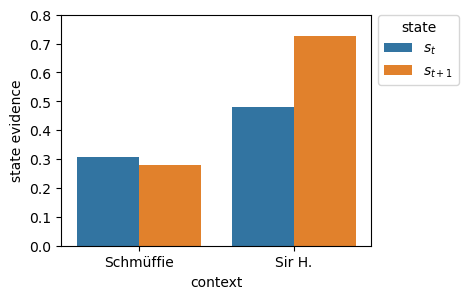

In [19]:
state_evidence_list = [evidence_state_schmueffie_s_t, evidence_state_schmueffie_s_t_1, evidence_state_sir_h_s_t, evidence_state_sir_h_s_t_1]

plot_state_evidence = pd.DataFrame({"state": ["$s_{t}$", "$s_{t+1}$", "$s_{t}$", "$s_{t+1}$"], "state evidence": state_evidence_list, 
                                     "context": ["Schmüffie", "Schmüffie", "Sir H.", "Sir H."]})

plt.figure(figsize=[4,3])
ax = sns.barplot(data=plot_state_evidence, x="context", y="state evidence", hue="state")
plt.ylim([0,0.8])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.03))
plt.show()

Overall, we have quite a bit more evidence for Sir Hidesalot from how the states evolved given the sequence of events (walk away, carry, purr), this is especially visible in the relative difference od the two organge bars.

#### <b>2.7. Action evidence</b>

For the action evidence, we check how well the action that was actually executed fits to our prior over how we typically behave in the different contexts

<img src="Inference_a_t.png" width="300"/>

For <b>Schmüffie</b> we had an action prior where we typically pet her.
$$p(a_{t}|c=\text{Schmüffie})=\begin{pmatrix} 0.67\\ 0.33  \end{pmatrix} \begin{matrix} \text{pet}\\ \text{carry} \end{matrix}$$
In our example, we chose carry, so we take the (lower) entry for carry

In [20]:
action_evidence_schmueffie = prior_actions_schmueffie[1]

print("Schmüffie action evidence")
print(action_evidence_schmueffie)

Schmüffie action evidence
0.33


Since we had executed the less likely action for $c=\text{Schmüffie}$, the evidence is low at $0.33$

For <b>Sir Hidesalot</b> we had an action prior where we typically carry him.
$$p(a_{t}|c=\text{Schmüffie})=\begin{pmatrix} 0.2\\ 0.8  \end{pmatrix} \begin{matrix} \text{pet}\\ \text{carry} \end{matrix}$$
In our example, we chose carry, so we take the (lower) entry for carry

In [21]:
action_evidence_sir_h = prior_actions_sir_h[1]

print("Sir Hidesalot action evidence")
print(action_evidence_sir_h)

Sir Hidesalot action evidence
0.8


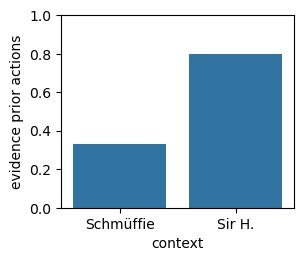

In [22]:
plot_ev_prior_actions = pd.DataFrame({"context": ["Schmüffie", "Sir H."], "evidence prior actions": [action_evidence_schmueffie, action_evidence_sir_h]})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_ev_prior_actions, x="context", y="evidence prior actions")
plt.ylim([0,1])
plt.show()

Since we had executed the more likely action for $c=\text{Sir Hidesalot}$, the evidence is high at $0.8$

#### <b>2.8. Total model evidence

As an intermediate result we can calculate the evidence we have collected from this small episode of interaction

<img src="Inference_model_evidence.png" width="300"/>

In [23]:
model_evidence_schmueffie = observation_evidence_schmueffie*state_evidence_schmueffie*action_evidence_schmueffie

print("Model evidence for context=Schmüffie")
print(model_evidence_schmueffie)

Model evidence for context=Schmüffie
0.027967500000000003


In [24]:
model_evidence_sir_h = observation_evidence_sir_h*state_evidence_sir_h*action_evidence_sir_h

print("Model evidence for context=Schmüffie")
print(model_evidence_sir_h)

Model evidence for context=Schmüffie
0.23545940000000007


Overall, we have more evidence for the events (walk away, carry, purr) coming from context Sir Hidesalot vs context Schmüffie. This is in a large part due to him preferring being carried and therefore purring afterwards with higher likelihood, and due to the high prior for carry in the Sir Hidesalot context.

We can stack and normalize these two evidences to get a normalized information signal from the lower part of the model to the higher part of the model

In [25]:
model_evidence = np.stack([model_evidence_schmueffie, model_evidence_sir_h],axis=0)
model_evidence = model_evidence / model_evidence.sum()

print("normalized context model evidence")
print(model_evidence)

normalized context model evidence
[0.10616797 0.89383203]


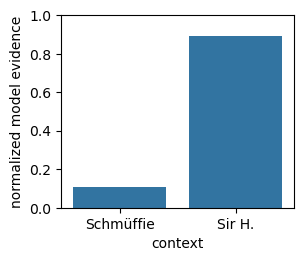

In [26]:
plot_model_evidence = pd.DataFrame({"context": ["Schmüffie", "Sir H."], "normalized model evidence": model_evidence})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_model_evidence, x="context", y="normalized model evidence")
plt.ylim([0,1])
plt.show()

So, if we were to base our context inference only on the model evidence from the lower level decision model, we would be 90% certain that we did in fact interact with Sir Hidesalot, not with Schmüffie. Note that this is without seeing any if the cats' features, and just based on the cat's and our own behavior!

#### <b>2.9. Context cue evidence</b>

As a last evidence term, there is the context cue evidence at the top of the model

<img src="Inference_context_cue.png" width="300"/>

Let us assume, that we did in fact see brown fur. We take the corresponding row from the context cue likelihood matrix
$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{context:} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{Schmüffie} & \text{Sir H.}\end{matrix}\\ p(o_{c}|c) = \textbf{observation:}\begin{matrix}\text{black}\\ \text{brown}\end{matrix}\begin{pmatrix} 0.9 & 0.1\\ 0.1 & 0.9 \end{pmatrix}$$

In [27]:
unnormalized_context_cue_likelihood_brown = context_cue_likelihood[1]

print("context cue row for brown")
print(unnormalized_context_cue_likelihood_brown)

normalized_context_cue_likelihood_brown = unnormalized_context_cue_likelihood_brown / unnormalized_context_cue_likelihood_brown.sum()

print("normalized context cue likelihood for brown")
print(normalized_context_cue_likelihood_brown)

context cue row for brown
[0.1 0.9]
normalized context cue likelihood for brown
[0.1 0.9]


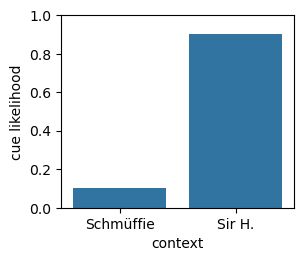

In [28]:
plot_cue_evidence = pd.DataFrame({"context": ["Schmüffie", "Sir H."], "cue likelihood": unnormalized_context_cue_likelihood_brown})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_cue_evidence, x="context", y="cue likelihood")
plt.ylim([0,1])
plt.show()

Given that we saw brown, we give 90% to Sir Hidesalot based on that cue.

#### <b>2.10. Context prior</b>

Lastly we have the context prior.

<img src="Inference_context_prior.png" width="300"/>

Well, this is short as we already specified the context prior above and don't have to do anything to it before we can use it below. The context prior was specified as
$$p(c) = \begin{pmatrix} 0.7\\0.3 \end{pmatrix} \begin{matrix} \text{Schmüffie}\\ \text{Sir H.}\end{matrix}$$
with a bias for Schmüffie.

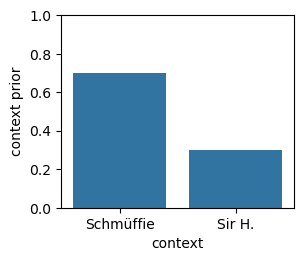

In [29]:
plot_prior_context = pd.DataFrame({"context": ["Schmüffie", "Sir H."], "context prior": prior_contexts})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_prior_context, x="context", y="context prior")
plt.ylim([0,1])
plt.show()

#### <b>2.11. Full inference</b>

Finally we combine all the elements

<img src="Inference_full.png" width="300"/>

We do so by multiplying all evidences and the prior value that belong to Schmüffie and all the ones that belong to Sir Hidesalot.

In [30]:
unnormalized_context_posterior = model_evidence * normalized_context_cue_likelihood_brown * prior_contexts

normalized_context_posterior = unnormalized_context_posterior/unnormalized_context_posterior.sum()

print("context posterior")
print(normalized_context_posterior)

context posterior
[0.02987444 0.97012556]


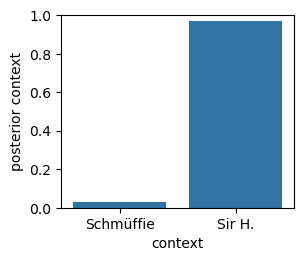

In [31]:
plot_posterior_context = pd.DataFrame({"context": ["Schmüffie", "Sir H."], "posterior context": normalized_context_posterior})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_posterior_context, x="context", y="posterior context")
plt.ylim([0,1])
plt.show()

At last, we have inferred a posterior probability for each context:

and we are 97% percent certain that we have in fact interacted with Sir Hidesalot. Both the model evidence and the context cue likelihood pointed in this direction, and taken together increased certainty. It was enough to make the posterior that certain, despite the prior pointing towards Schmüffie!